# Gaussian Mixture Models on Source activity simulation of a selected brain region¶

In [7]:
import os
import sys
import time

In [8]:
import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sns
from scipy import optimize
import matplotlib.pyplot as plt

In [480]:
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal as mvn

from matplotlib.patches import Ellipse


In [9]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

In [10]:
%pylab inline

sns.set_style("white")
sns.set_context("talk")

Populating the interactive namespace from numpy and matplotlib


In [11]:
cwd = os.getcwd()
cwd

'/Users/meysamhashemi/WORK/CurrentWork_codes/PPCA'

In [12]:
Sim_data=np.load(cwd+'/data_input_files/data_input_mpr_slnet_decim360_001.npz')

In [13]:
for elemets in Sim_data.keys():
    print (elemets)

nd
nn
nt
dt
nsigma
Ts
t0
ds_decim
G
SC
Obs_v
Obs_r
delta_true
eta_true
J_true
rlim
vlim


In [14]:
nn=Sim_data['nn']
Ts=Sim_data['Ts']
Obs_v=Sim_data['Obs_v']
Obs_r=Sim_data['Obs_r']

In [15]:
Obs_v.shape, Ts.shape

((84, 1667), (1667,))

In [16]:
def scale(X, x_min, x_max):
    nom = (X-X.min(axis=0))*(x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom==0] = 1
    return x_min + nom/denom 

In [17]:
Obs_v_scaled = scale(Obs_v, -.15, 1.1)
#Obs_v_scaled = scale(Obs_v, 1., 2.)

In [18]:
Obs_v_scaled.shape

(84, 1667)

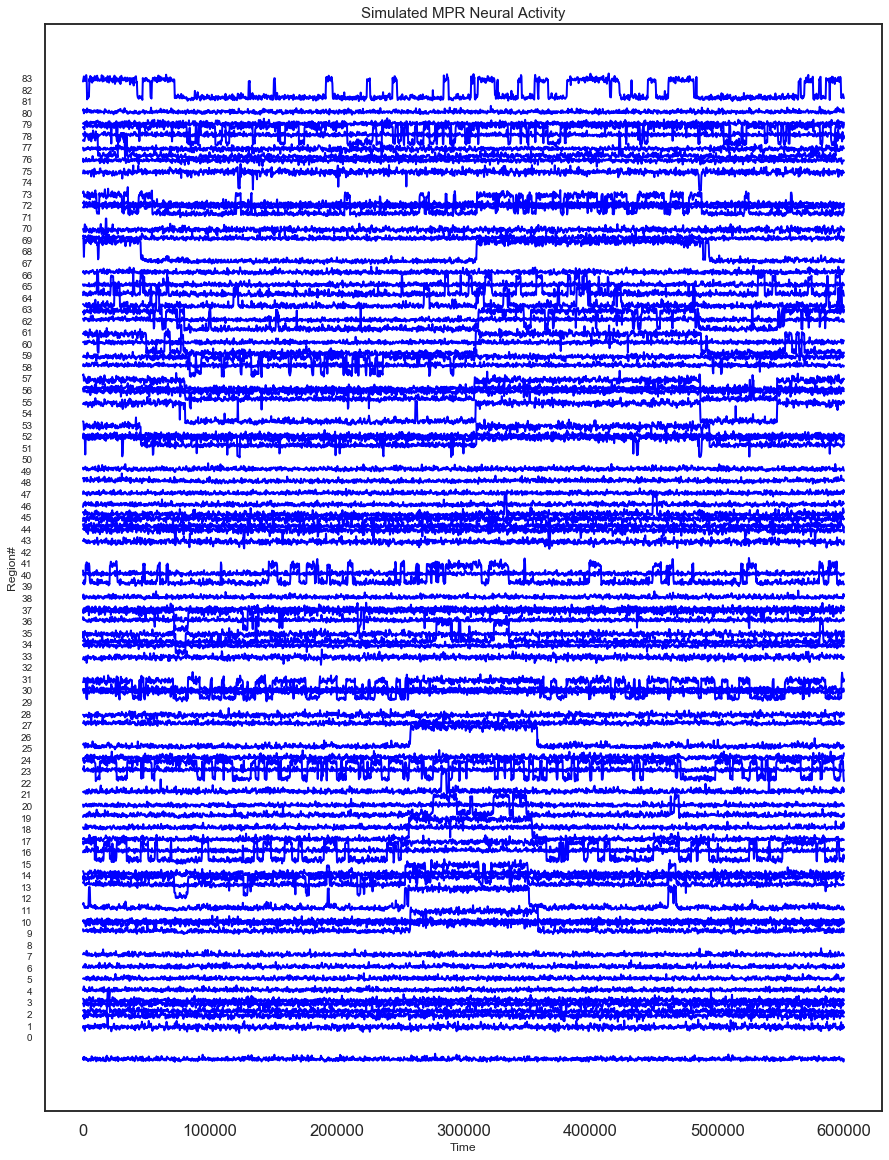

In [19]:
plt.figure(figsize=(15,20))
plt.plot(Ts, Obs_v.T + np.r_[0:nn], '-b', linewidth=2)
plt.yticks(np.r_[0:nn], np.r_[0:nn], fontsize=10)
plt.title("Simulated MPR Neural Activity",fontsize=15)
plt.xlabel('Time',fontsize=12)
plt.ylabel('Region#',fontsize=12)
plt.savefig(os.path.join(cwd+'/Figs',"MPR_SyntheticSource.png"))
plt.show()

# Selecting Some node activities 

In [20]:
Ns_=np.array([0, 16, 36, 66, 78, 83])

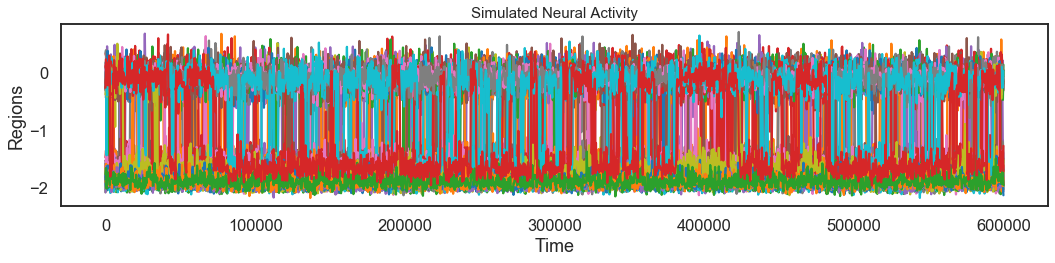

In [21]:
plt.figure(figsize=(15, 4))
plt.plot(Ts, Obs_v.T)
plt.xlabel("Time")
plt.ylabel("Regions")
plt.title("Simulated Neural Activity",fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/Figs',"MPR_Selected_SyntheticSource_nn.png"))
plt.show()     

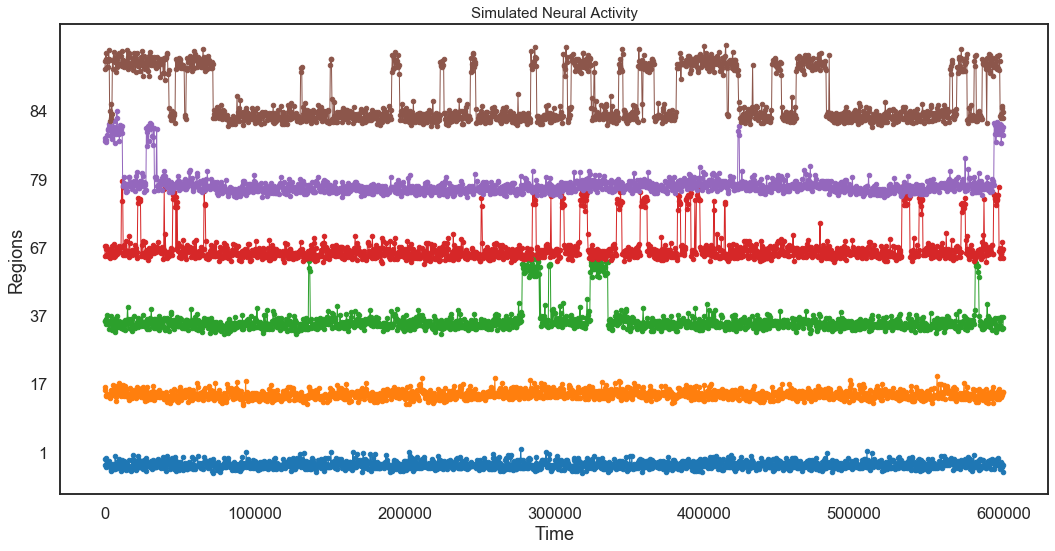

In [22]:
plt.figure(figsize=(15, 8))
i=0
for ii in (Ns_):
    i=i+1
    plt.plot(Ts, Obs_v[ii, :].T+ 2*i, '.-', lw=1)
plt.yticks(2*np.r_[0:Ns_.size]+.5, Ns_+1)
plt.xlabel("Time")
plt.ylabel("Regions")
plt.title("Simulated Neural Activity",fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/Figs',"MPR_Selected_SyntheticSourceNodes_nn.png"))
plt.show()     

In [24]:
Obs_v.shape, Obs_r.shape

((84, 1667), (84, 1667))

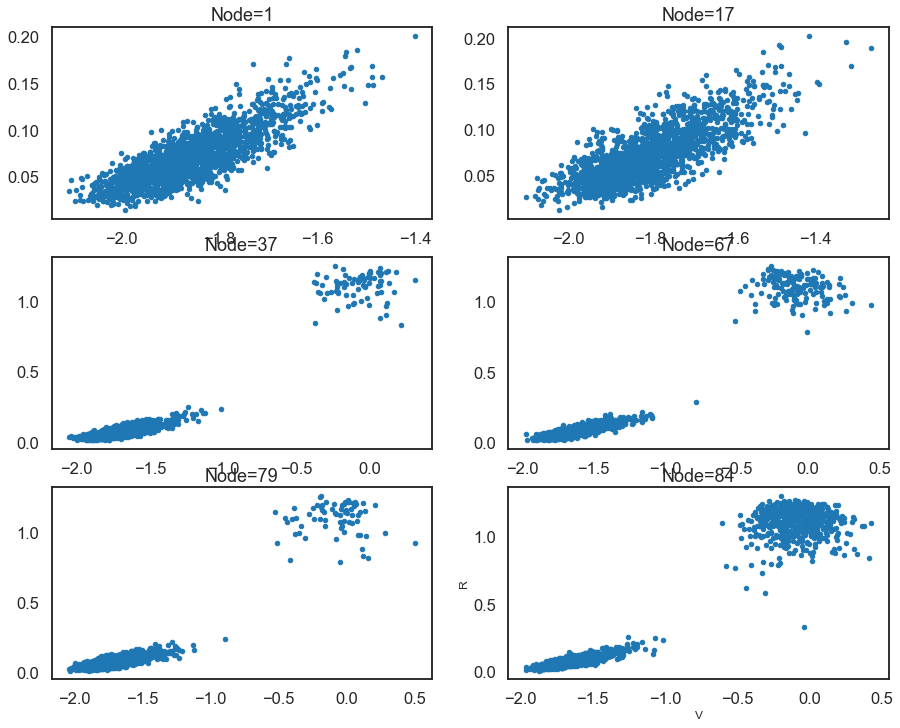

In [25]:
plt.figure(figsize=(15, 12))
i=0
for ii in (Ns_):
    i=i+1
    plt.subplot(3,2,i)
    plt.plot(Obs_v[ii, :], Obs_r[ii, :], '.', lw=.1)
    plt.title("Node={:d}".format((ii)+1))
plt.xlabel('V',fontsize=12)
plt.ylabel('R',fontsize=12)
plt.savefig(os.path.join(cwd+'/Figs',"MPR_Selected_SyntheticSourcePhasePlaneRV.png"))
plt.show()     

In [ ]:
def plot_kmeans(kmeans, X, n_clusters=D, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))


In [ ]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        e=ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
   


    e.set_alpha(0.5)
    e.set_facecolor('r')
    e.set_zorder(10);
    ax.add_artist(e);

In [ ]:
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1],  s=40, cmap='viridis', color='b', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

# GMM on a selected brain region


In [348]:
ns=0

In [349]:
Obs_v[ns, :].shape, Obs_r[ns, :].shape

((1667,), (1667,))

In [350]:
len(Obs_v[ns, :])

1667

In [359]:
N = len(Obs_v[ns, :])  # number of data points
D=1

In [360]:
x_train=np.stack((Obs_v[ns, :]+1.86, Obs_r[ns, :]-.07))

In [361]:
x_train.shape

(2, 1667)

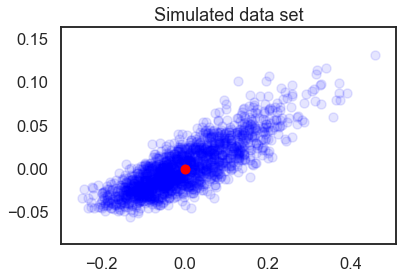

In [362]:
plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
#plt.axis([-2.2, -1.25, 0, .2])
plt.plot(0,0,'ro')
plt.title("Simulated data set")
plt.show()

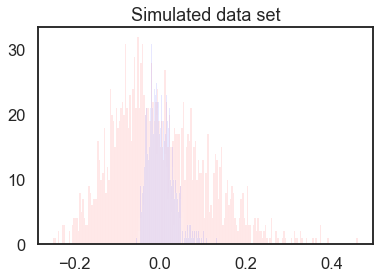

In [363]:
#plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.hist(x_train[0, :], color='r', alpha=0.1, bins=200)
plt.hist(x_train[1, :], color='b', alpha=0.1, bins=200)
#plt.axis([-10, 10, -10, 10])
plt.title("Simulated data set")
plt.show()

In [364]:
x_train.shape

(2, 1667)

In [365]:
X=x_train.T

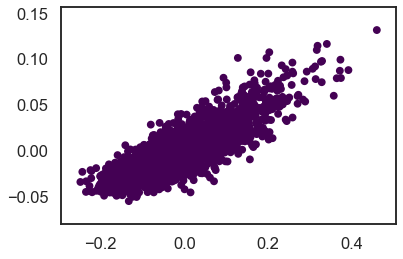

In [366]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(D, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

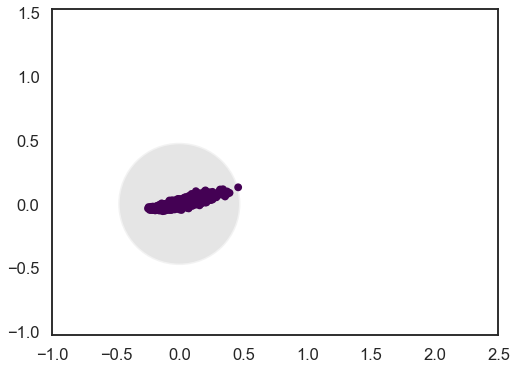

In [367]:
fig, ax = plt.subplots(figsize=(8, 6))
kmeans = KMeans(n_clusters=D, random_state=0)
plot_kmeans(kmeans, X)
ax.set_xlim(-1, 2.5)
ax.set_ylim(-2, 2.5)

plt.show()

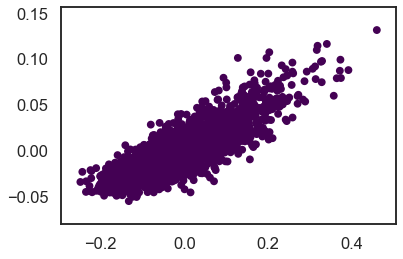

In [368]:
gmm = GMM(n_components=D).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

In [369]:
probs = gmm.predict_proba(X)

In [370]:
X.shape, probs.shape

((1667, 2), (1667, 1))

In [371]:
gmm = GMM(n_components=D, covariance_type='full', random_state=0)

In [372]:
gmm

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=1, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

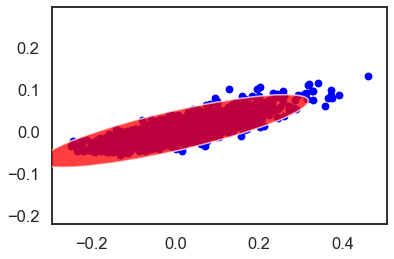

In [373]:
plot_gmm(gmm, X)

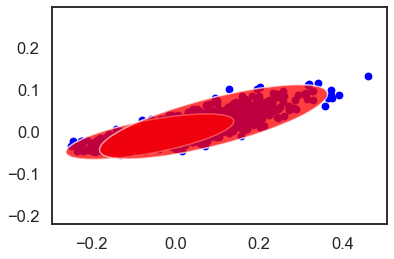

In [375]:
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, X)

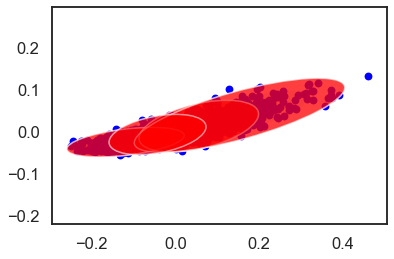

In [376]:
gmm4 = GMM(n_components=4, covariance_type='full', random_state=0)
plot_gmm(gmm4, X)

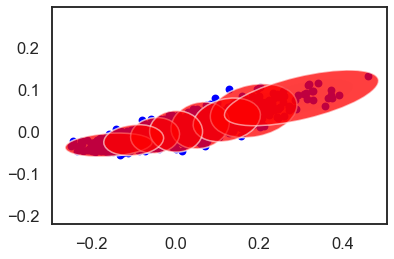

In [377]:
gmm8 = GMM(n_components=8, covariance_type='full', random_state=0)
plot_gmm(gmm8, X)

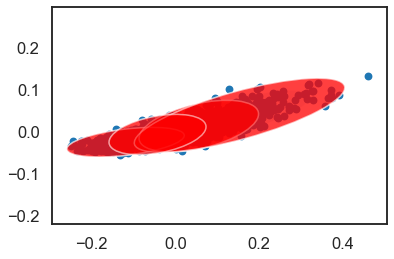

In [378]:
gmm16 = GMM(n_components=4, covariance_type='full', random_state=0)
plot_gmm(gmm16, X, label=False)

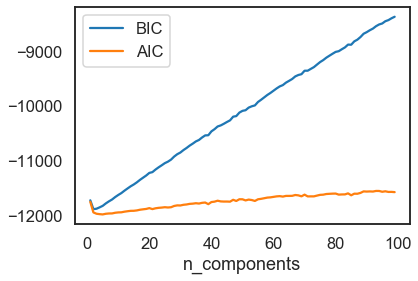

In [379]:
n_components = np.arange(1, 100)

models = [GMM(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [382]:
np.argmin([m.bic(X) for m in models])

1

In [383]:
np.argmin([m.aic(X) for m in models])

4

In [384]:
X.shape

(1667, 2)

In [385]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(X)
data.shape

(1667, 2)

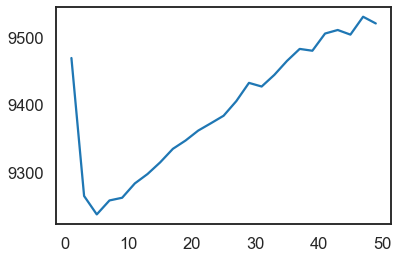

In [386]:
n_components = np.arange(1, 50, 2)
models = [GMM(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

In [388]:
np.argmin(aics)

2

# GMM on a selected brain region


In [389]:
ns=36

In [390]:
Obs_v[ns, :].shape, Obs_r[ns, :].shape

((1667,), (1667,))

In [391]:
len(Obs_v[ns, :])

1667

In [392]:
N = len(Obs_v[ns, :])  # number of data points
D=2

In [393]:
x_train=np.stack((Obs_v[ns, :]+1.86, Obs_r[ns, :]-.07))

In [394]:
x_train.shape

(2, 1667)

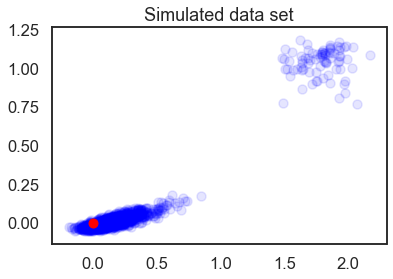

In [395]:
plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
#plt.axis([-2.2, -1.25, 0, .2])
plt.plot(0,0,'ro')
plt.title("Simulated data set")
plt.show()

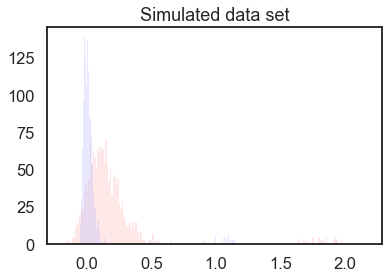

In [396]:
#plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.hist(x_train[0, :], color='r', alpha=0.1, bins=200)
plt.hist(x_train[1, :], color='b', alpha=0.1, bins=200)
#plt.axis([-10, 10, -10, 10])
plt.title("Simulated data set")
plt.show()

In [397]:
x_train.shape

(2, 1667)

In [398]:
X=x_train.T

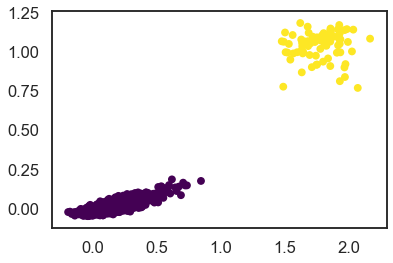

In [399]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(D, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

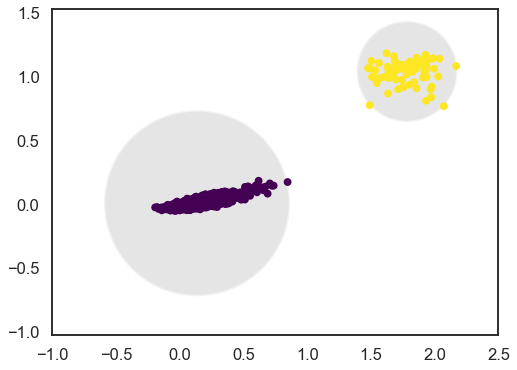

In [400]:
fig, ax = plt.subplots(figsize=(8, 6))
kmeans = KMeans(n_clusters=D, random_state=0)
plot_kmeans(kmeans, X)
ax.set_xlim(-1, 2.5)
ax.set_ylim(-2, 2.5)

plt.show()

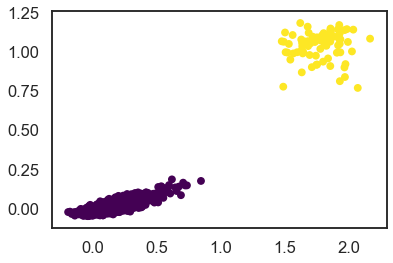

In [401]:
gmm = GMM(n_components=D).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

In [402]:
probs = gmm.predict_proba(X)

In [403]:
X.shape, probs.shape

((1667, 2), (1667, 2))

In [404]:
gmm = GMM(n_components=D, covariance_type='full', random_state=0)

In [405]:
gmm

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

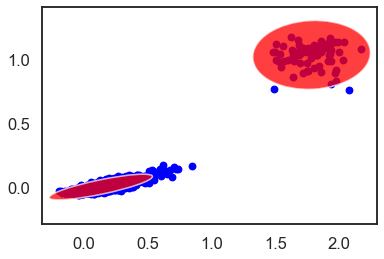

In [406]:
plot_gmm(gmm, X)

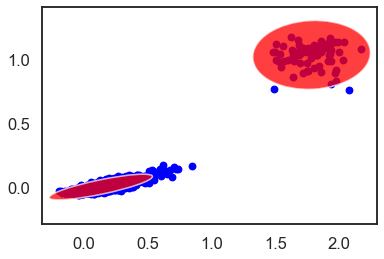

In [407]:
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, X)

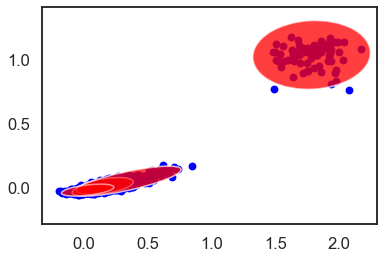

In [408]:
gmm4 = GMM(n_components=4, covariance_type='full', random_state=0)
plot_gmm(gmm4, X)

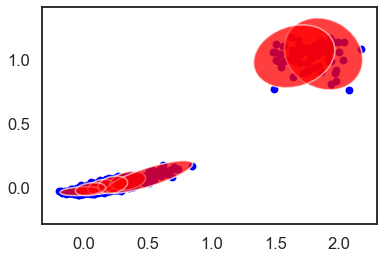

In [409]:
gmm8 = GMM(n_components=8, covariance_type='full', random_state=0)
plot_gmm(gmm8, X)

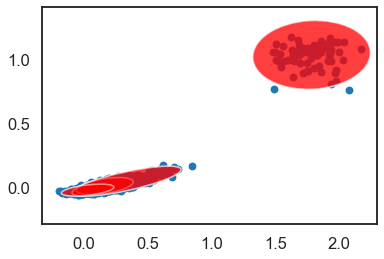

In [410]:
gmm16 = GMM(n_components=4, covariance_type='full', random_state=0)
plot_gmm(gmm16, X, label=False)

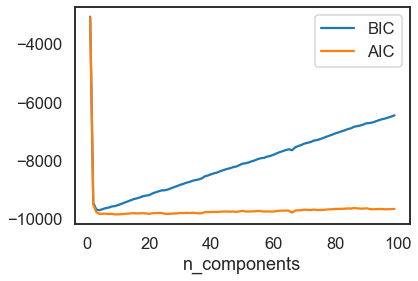

In [411]:
n_components = np.arange(1, 100)

models = [GMM(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [412]:
np.argmin([m.bic(X) for m in models])

3

In [413]:
np.argmin([m.aic(X) for m in models])

8

In [414]:
X.shape

(1667, 2)

In [415]:
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(X)
data.shape

(1667, 2)

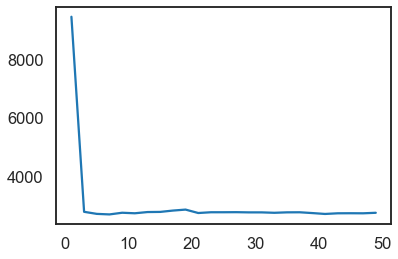

In [416]:
n_components = np.arange(1, 50, 2)
models = [GMM(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

In [417]:
np.argmin(aics)

3

# GMM on a selected brain region


In [643]:
ns=83

In [644]:
Obs_v[ns, :].shape, Obs_r[ns, :].shape

((1667,), (1667,))

In [645]:
len(Obs_v[ns, :])

1667

In [646]:
N = len(Obs_v[ns, :])  # number of data points
D=2

In [647]:
x_train=np.stack((Obs_v[ns, :]+1.86, Obs_r[ns, :]-.07))

In [648]:
x_train.shape

(2, 1667)

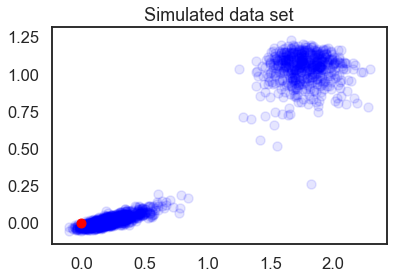

In [424]:
plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
#plt.axis([-2.2, -1.25, 0, .2])
plt.plot(0,0,'ro')
plt.title("Simulated data set")
plt.show()

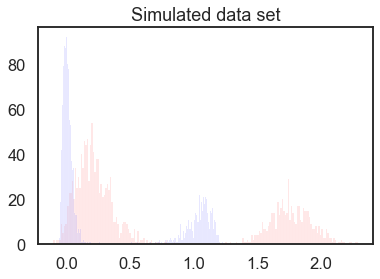

In [425]:
#plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.hist(x_train[0, :], color='r', alpha=0.1, bins=200)
plt.hist(x_train[1, :], color='b', alpha=0.1, bins=200)
#plt.axis([-10, 10, -10, 10])
plt.title("Simulated data set")
plt.show()

In [426]:
x_train.shape

(2, 1667)

In [661]:
X=x_train.T

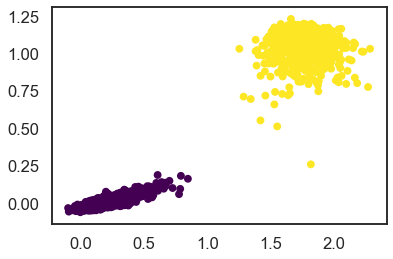

In [428]:
# Plot the data with K Means Labels
kmeans = KMeans(D, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

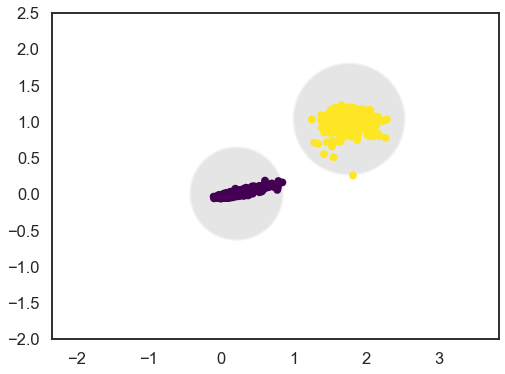

In [429]:
fig, ax = plt.subplots(figsize=(8, 6))
kmeans = KMeans(n_clusters=D, random_state=0)
plot_kmeans(kmeans, X)
ax.set_xlim(-1, 2.5)
ax.set_ylim(-2, 2.5)

plt.show()

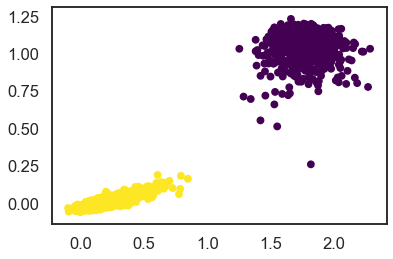

In [430]:
gmm = GMM(n_components=D).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

In [431]:
probs = gmm.predict_proba(X)

In [432]:
X.shape, probs.shape

((1667, 2), (1667, 2))

In [433]:
gmm = GMM(n_components=D, covariance_type='full', random_state=0)

In [434]:
gmm

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

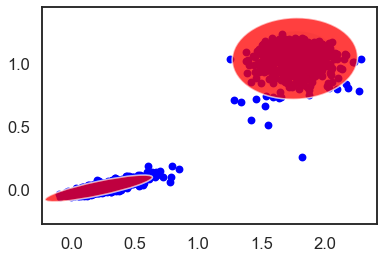

In [435]:
plot_gmm(gmm, X)

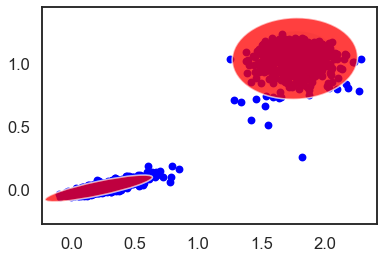

In [436]:
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, X)

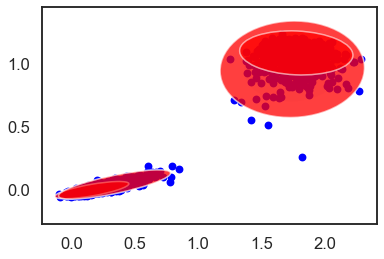

In [437]:
gmm4 = GMM(n_components=4, covariance_type='full', random_state=0)
plot_gmm(gmm4, X)

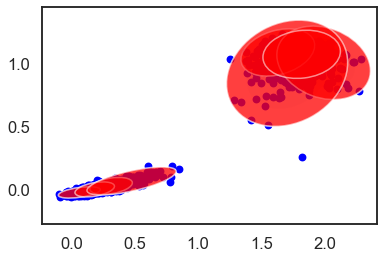

In [438]:
gmm8 = GMM(n_components=8, covariance_type='full', random_state=0)
plot_gmm(gmm8, X)

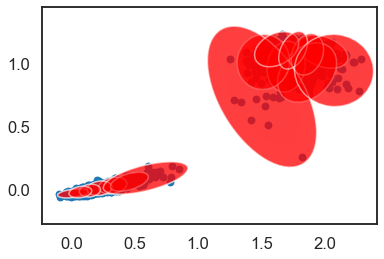

In [439]:
gmm16 = GMM(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, X, label=False)

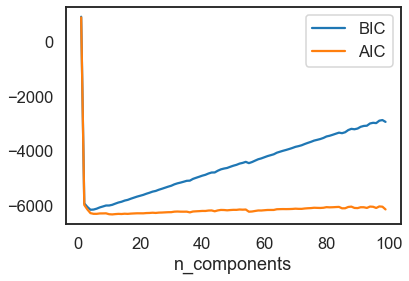

In [440]:
n_components = np.arange(1, 100)

models = [GMM(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [441]:
np.argmin([m.bic(X) for m in models])

3

In [442]:
np.argmin([m.aic(X) for m in models])

10

In [452]:
X.shape

(1667, 2)

In [464]:
PCA?

Init signature:
PCA(
    n_components=None,
    copy=True,
    whiten=False,
    svd_solver='auto',
    tol=0.0,
    iterated_power='auto',
    random_state=None,
)
Docstring:     
Principal component analysis (PCA).

Linear dimensionality reduction using Singular Value Decomposition of the
data to project it to a lower dimensional space. The input data is centered
but not scaled for each feature before applying the SVD.

It uses the LAPACK implementation of the full SVD or a randomized truncated
SVD by the method of Halko et al. 2009, depending on the shape of the input
data and the number of components to extract.

It can also use the scipy.sparse.linalg ARPACK implementation of the
truncated SVD.

Notice that this class does not support sparse input. See
:class:`TruncatedSVD` for an alternative with sparse data.

Read more in the :ref:`User Guide <PCA>`.

Parameters
----------
n_components : int, float, None or str
    Number of components to keep.
    if n_components is not set all

In [675]:
X=x_train.T

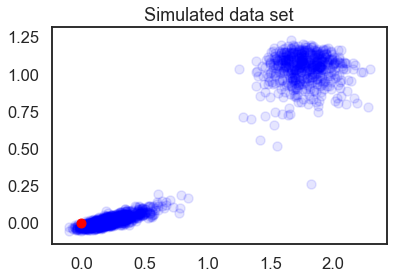

In [676]:
plt.scatter(X[:,0], X[:,1], color='blue', alpha=0.1)
#plt.axis([-2.2, -1.25, 0, .2])
plt.plot(0,0,'ro')
plt.title("Simulated data set")
plt.show()

In [677]:
X.shape

(1667, 2)

In [666]:
pca = PCA(n_components=2)
pca_x=pca.fit(X)

In [667]:
pca_x

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [668]:
print(pca_x.components_)


[[ 0.83867349  0.54463454]
 [ 0.54463454 -0.83867349]]


In [669]:
print(pca_x.explained_variance_)


[0.79472405 0.00733001]


In [670]:
pca_x.mean_

array([0.73616789, 0.35582348])

In [671]:
print(pca_x.mean_[1]/pca_x.mean_[0])

0.4833455556175158


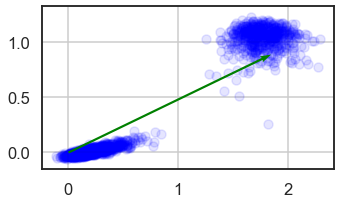

In [678]:
XX = np.array((0.))
Y= np.array((0.0))
U = pca_x.mean_[0]
V = pca_x.mean_[1]

fig, ax = plt.subplots(1,1,figsize=(12,3))
plt.scatter(X[:,0], X[:,1], color='blue', alpha=0.1)
q = ax.quiver(XX, Y, U, V,units='xy' ,scale=.4, color='green')
plt.grid()
ax.set_aspect('equal')
# plt.xlim(-2,0)
# plt.ylim(0,1)
plt.show()

In [679]:
pca = PCA(n_components = 2, whiten=True)
pca_x = pca.fit_transform(X)


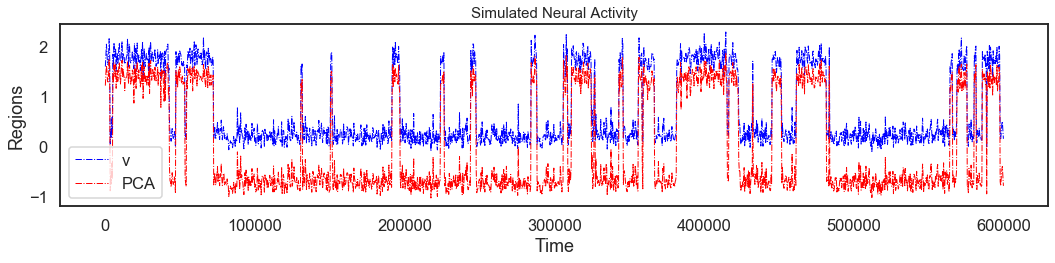

In [680]:
plt.figure(figsize=(15, 4))
plt.plot(Ts, X[:,0], '-.b', lw=1, label='v')
#plt.plot(Ts, X[:,1], 'b',  lw=1, label='r')

plt.plot(Ts, pca_x[:,0],'-.r',  lw=1, label='PCA')

plt.xlabel("Time")
plt.ylabel("Regions")
plt.title("Simulated Neural Activity",fontsize=15)
plt.tight_layout()
plt.legend()
plt.savefig(os.path.join(cwd+'/Figs',"MPR_Selected_SyntheticSource_nn.png"))
plt.show()     

In [681]:
gmm = GMM(n_components=2, covariance_type='full').fit(pca_x)
prediction_gmm = gmm.predict(pca_x)
probs = gmm.predict_proba(pca_x)

In [682]:
gmm.covariances_.shape

(2, 2, 2)

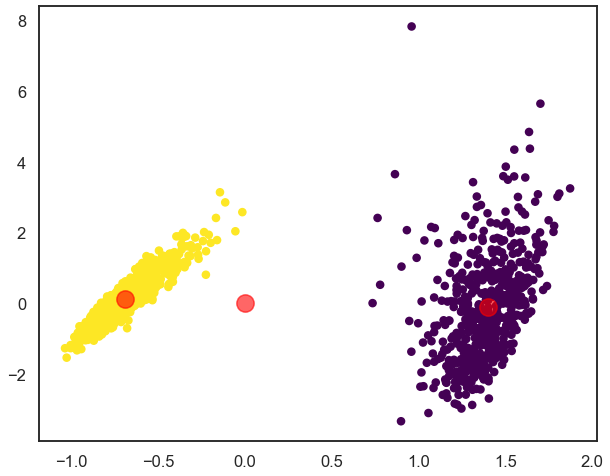

In [683]:
centers = np.zeros((3,2))
for i in range(2):
    density = mvn(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(pca_x)
    centers[i, :] = pca_x[np.argmax(density)]

plt.figure(figsize = (10,8))
plt.scatter(pca_x[:, 0], pca_x[:, 1],c=prediction_gmm ,s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1],c='r', s=300, alpha=0.6);

In [684]:
gmm = GMM(n_components=3, covariance_type='full').fit(pca_x)
prediction_gmm = gmm.predict(pca_x)
probs = gmm.predict_proba(pca_x)

In [552]:
gmm.covariances_.shape

(3, 2, 2)

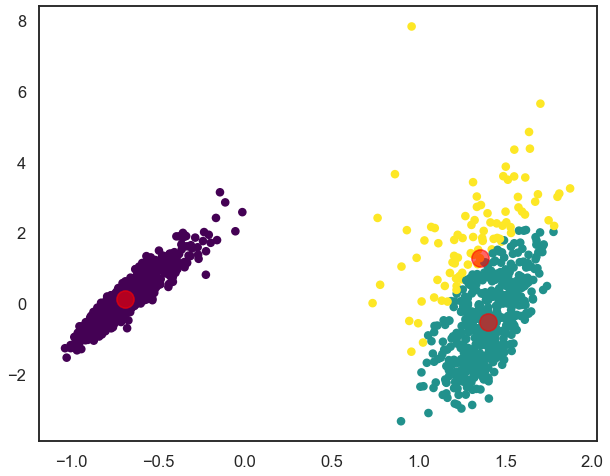

In [532]:
centers = np.zeros((3,2))
for i in range(3):
    density = mvn(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(pca_x)
    centers[i, :] = pca_x[np.argmax(density)]

plt.figure(figsize = (10,8))
plt.scatter(pca_x[:, 0], pca_x[:, 1],c=prediction_gmm ,s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1],c='r', s=300, alpha=0.6);

In [556]:
gmm = GMM(n_components=5, covariance_type='full').fit(pca_x)
prediction_gmm = gmm.predict(pca_x)
probs = gmm.predict_proba(pca_x)

In [557]:
gmm.covariances_.shape

(5, 2, 2)

(1667,)
(1667,)
(1667,)


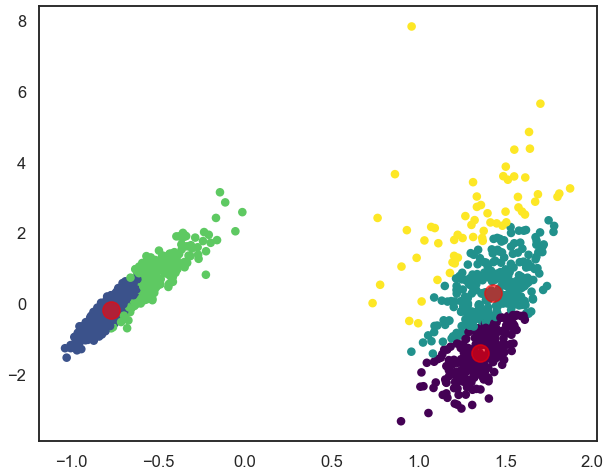

In [563]:
centers = np.zeros((3,2))
for i in range(3):
    density = mvn(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(pca_x)
    centers[i, :] = pca_x[np.argmax(density)]

plt.figure(figsize = (10,8))
plt.scatter(pca_x[:, 0], pca_x[:, 1],c=prediction_gmm ,s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1],c='r', s=300, alpha=0.6);

In [564]:
gmm = GMM(n_components=15, covariance_type='full').fit(pca_x)
prediction_gmm = gmm.predict(pca_x)
probs = gmm.predict_proba(pca_x)

In [565]:
gmm.covariances_.shape

(15, 2, 2)

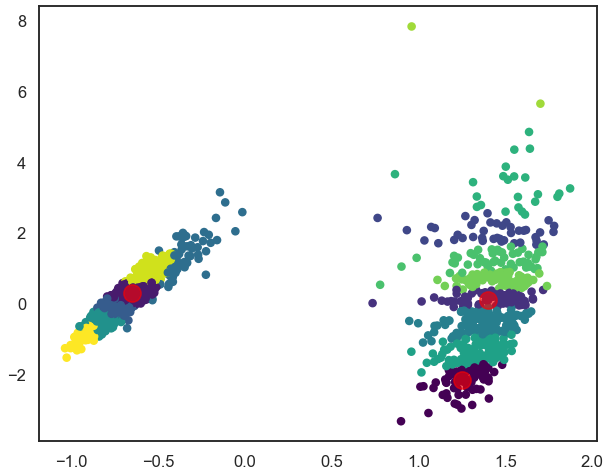

In [566]:
centers = np.zeros((3,2))
for i in range(3):
    density = mvn(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(pca_x)
    centers[i, :] = pca_x[np.argmax(density)]

plt.figure(figsize = (10,8))
plt.scatter(pca_x[:, 0], pca_x[:, 1],c=prediction_gmm ,s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1],c='r', s=300, alpha=0.6);

In [567]:
centers

array([[ 1.25119619, -2.17984776],
       [-0.65078213,  0.2988488 ],
       [ 1.40231976,  0.08898859]])

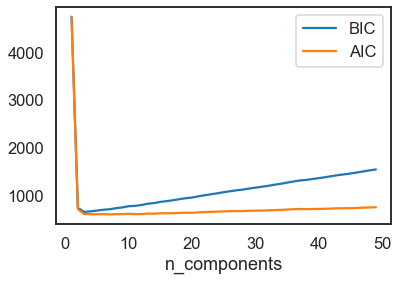

In [513]:
n_components = np.arange(1, 50, 1)
models = [GMM(n, covariance_type='full', random_state=10)
          for n in n_components]

bics = [model.fit(data).bic(data) for model in models]
aics = [model.fit(data).aic(data) for model in models]

plt.plot(n_components, bics , label='BIC')
plt.plot(n_components, aics, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [546]:
np.argmin(bics), np.argmin(aics), 

(2, 6)

In [547]:
n_components[2]

3